
# Q learning (Q-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # End of training episodes/ Goal-sequence, is task/goal done/reached?
    dones = tf.placeholder(tf.float32, [None], name='done')
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, dones

In [7]:
# G: generator/predictor for current action and next state 
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fuse/merge the prev_actions and current states
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions logits and next states logits
        return actions_logits, next_states_logits

In [8]:
# D: discriminator/Qfunction for previous/current action and current/next state 
def discriminator(actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fuse/merge the actions and states
        x_fused = tf.concat(axis=1, values=[actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.sigmoid(logits)

        # return actions logits and next states logits
        return logits

In [9]:
# Forward pass using model functions G & D
def model_output(prev_actions, states, # model input data for G and ~actions, ~next_states
                 state_size, action_size, hidden_size): # model init for G and D
    
    # Calculating current actions and next states logits
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states, 
                                                   action_size=action_size, state_size=state_size, 
                                                   hidden_size=hidden_size)

    # Calculating Qs
    Qs = discriminator(actions=prev_actions_onehot, states=states, hidden_size=hidden_size)

    
    # Returning actions_logits, next_states_logits and Qs as the output
    return actions_logits, next_states_logits, Qs

In [10]:
# Calculating the loss and backward pass/backpropagation of the loss/error
def model_loss(actions_logits, next_states_logits, # model input data for G and ~actions, ~next_states
               actions, next_states, # model input data for G nextQs & D nextQs
               dones, # model input data for ~nextQs and nextQs end of episodes
               Qs, gamma, # model input data for targetQs
               state_size, action_size, hidden_size): # model init for G and D
    
    # Calculating nextQs logits
    g_nextQs = discriminator(actions=actions_logits, states=next_states_logits, hidden_size=hidden_size, 
                             reuse=True)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    d_nextQs = discriminator(actions=actions_onehot, states=next_states, hidden_size=hidden_size, reuse=True)
    
    # Masking the nextQs using dones/end-of-episodes
    #actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dones_mask = tf.reshape(tensor=(1 - tf.cast(dtype=actions_logits.dtype, x=dones)), shape=[-1, 1]) 
    g_nextQs_masked = tf.multiply(g_nextQs, dones_mask)
    d_nextQs_masked = tf.multiply(d_nextQs, dones_mask)
    g_nextQs = tf.reduce_max(g_nextQs_masked, axis=1)
    d_nextQs = tf.reduce_max(d_nextQs_masked, axis=1)
    
    # Bellman equaion for calculating total rewards using current reward + total future rewards/nextQs
    #targetQs = qs + (0.99 * nextQs)
    # Current reward or Rt/rt
    # Calculating rewards/Rs as prob/sigmoid of Qs, i.e. between 0-1
    qs = tf.sigmoid(Qs) # qt
    g_targetQs = qs + (gamma * g_nextQs)
    d_targetQs = qs + (gamma * d_nextQs)
    
    # Calculating the loss: logits/predictions vs labels
    g_loss = tf.reduce_mean(tf.square(Qs - g_targetQs))
    d_loss = tf.reduce_mean(tf.square(Qs - d_targetQs))

    return g_loss, d_loss

In [11]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for current actions and next states prediction
    :param d_loss: Discriminator loss Tensor for nextQs/logits prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.dones = model_input(
            state_size=state_size)
        
        # Output of model: forward pass of the model using model functions/architecture
        self.actions_logits, self.next_states_logits, self.Qs = model_output(
            action_size=action_size, state_size=state_size, hidden_size=hidden_size, # model init parameters
            prev_actions=self.prev_actions, states=self.states) # model data inputs

        # Create the Model: calculating the loss and forwad pass
        self.g_loss, self.d_loss = model_loss(
            action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma, # model init parameters
            actions=self.actions, next_states=self.next_states, dones=self.dones, # model input data
            actions_logits=self.actions_logits, next_states_logits=self.next_states_logits, Qs=self.Qs) # model output 

        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [15]:
train_episodes = 2500          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [16]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
             gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, reward, done, info = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()# At
    next_state, reward, done, info = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        
        # Print out reward and done and check if they are the same: They are NOT.
        #print('if done is true:', reward, done)
        
        # # the episode ends so no next state
        # next_state = np.zeros(state.shape)
                
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, reward, done, info = env.step(prev_action)
    else:
        # Print out reward and done and check if they are the same!
        #print('else done is false:', reward, done)
        
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

In [18]:
# At-1, St, At, St+1
prev_action, np.array([prev_action]).shape, np.array(prev_action).shape

(0, (1,), ())

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list, d_loss_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss, d_loss = 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model using prev_action and current state
                feed_dict = {model.prev_actions: np.array([prev_action]),
                             model.states: np.array([state])}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action

            # # Debugging
            # print('state.shape, state.reshape((1, *state.shape)).shape:',
            #       state.shape, state.reshape((1, *state.shape)).shape)
            
            # Take action, get new state and reward
            next_state, reward, done, info = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, info = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Updating the model: Calculating Qs using states and actions and Qt = rs/qs + (gamma * nextQs) 
            feed_dict = {model.prev_actions: prev_actions,
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states,
                         model.dones: dones}
            # g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            # d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _, d_loss, _ = sess.run([model.g_loss, model.g_opt, 
                                             model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 11.0 Training g_loss: 0.3310 Training d_loss: 0.2264 Explore P: 0.9989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 10.0 Training g_loss: 0.2119 Training d_loss: 0.2057 Explore P: 0.9979
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 17.0 Training g_loss: 0.1018 Training d_loss: 0.1693 Explore P: 0.9962
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 44.0 Training g_loss: 0.0593 Training d_loss: 0.1718 Explore P: 0.9919
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 34 Total reward: 22.0 Training g_loss: 0.0690 Training d_loss: 0.1734 Explore P: 0.9259
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 43.0 Training g_loss: 0.0848 Training d_loss: 0.1905 Explore P: 0.9220
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 23.0 Training g_loss: 0.0957 Training d_loss: 0.1968 Explore P: 0.9199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 22.0 Training g_loss: 0.0864 Training d_loss: 0.1874 Explore P: 0.9179
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 67 Total reward: 26.0 Training g_loss: 0.0929 Training d_loss: 0.1934 Explore P: 0.8634
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 45.0 Training g_loss: 0.0640 Training d_loss: 0.1739 Explore P: 0.8595
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 9.0 Training g_loss: 0.0822 Training d_loss: 0.1815 Explore P: 0.8588
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 58.0 Training g_loss: 0.0944 Training d_loss: 0.1973 Explore P: 0.8539
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 100 Total reward: 44.0 Training g_loss: 0.0866 Training d_loss: 0.1853 Explore P: 0.8041
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 17.0 Training g_loss: 0.0800 Training d_loss: 0.1845 Explore P: 0.8027
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 13.0 Training g_loss: 0.0890 Training d_loss: 0.1910 Explore P: 0.8017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 103 Total reward: 20.0 Training g_loss: 0.0545 Training d_loss: 0.1576 Explore P: 0.8001
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 133 Total reward: 16.0 Training g_loss: 0.0974 Training d_loss: 0.1988 Explore P: 0.7588
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 134 Total reward: 17.0 Training g_loss: 0.0829 Training d_loss: 0.1930 Explore P: 0.7576
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 14.0 Training g_loss: 0.0843 Training d_loss: 0.1871 Explore P: 0.7565
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 136 Total reward: 12.0 Training g_loss: 0.0889 Training d_loss: 0.1941 Explore P: 0.7556
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 165 Total reward: 8.0 Training g_loss: 0.0936 Training d_loss: 0.2004 Explore P: 0.7195
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 166 Total reward: 9.0 Training g_loss: 0.0926 Training d_loss: 0.1964 Explore P: 0.7189
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 12.0 Training g_loss: 0.0875 Training d_loss: 0.1859 Explore P: 0.7180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 13.0 Training g_loss: 0.0799 Training d_loss: 0.1705 Explore P: 0.7171
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 198 Total reward: 28.0 Training g_loss: 0.0650 Training d_loss: 0.1699 Explore P: 0.6846
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 199 Total reward: 9.0 Training g_loss: 0.1028 Training d_loss: 0.1990 Explore P: 0.6840
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 200 Total reward: 20.0 Training g_loss: 0.0744 Training d_loss: 0.1730 Explore P: 0.6826
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 201 Total reward: 8.0 Training g_loss: 0.0821 Training d_loss: 0.1888 Explore P: 0.6821
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 230 Total reward: 12.0 Training g_loss: 0.0533 Training d_loss: 0.1570 Explore P: 0.6544
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 231 Total reward: 25.0 Training g_loss: 0.0735 Training d_loss: 0.1797 Explore P: 0.6528
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 24.0 Training g_loss: 0.0758 Training d_loss: 0.1802 Explore P: 0.6512
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 13.0 Training g_loss: 0.0917 Training d_loss: 0.1905 Explore P: 0.6504
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 262 Total reward: 11.0 Training g_loss: 0.0870 Training d_loss: 0.1853 Explore P: 0.6215
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 263 Total reward: 16.0 Training g_loss: 0.0791 Training d_loss: 0.1812 Explore P: 0.6205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 264 Total reward: 11.0 Training g_loss: 0.0547 Training d_loss: 0.1712 Explore P: 0.6198
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 265 Total reward: 10.0 Training g_loss: 0.0633 Training d_loss: 0.1739 Explore P: 0.6192
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 295 Total reward: 12.0 Training g_loss: 0.0448 Training d_loss: 0.1572 Explore P: 0.5874
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 296 Total reward: 12.0 Training g_loss: 0.0793 Training d_loss: 0.1731 Explore P: 0.5867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 297 Total reward: 10.0 Training g_loss: 0.0811 Training d_loss: 0.1750 Explore P: 0.5862
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 298 Total reward: 9.0 Training g_loss: 0.0982 Training d_loss: 0.1903 Explore P: 0.5857
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 327 Total reward: 14.0 Training g_loss: 0.0887 Training d_loss: 0.1908 Explore P: 0.5627
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 328 Total reward: 12.0 Training g_loss: 0.0698 Training d_loss: 0.1757 Explore P: 0.5620
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 329 Total reward: 17.0 Training g_loss: 0.0882 Training d_loss: 0.1839 Explore P: 0.5611
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 330 Total reward: 17.0 Training g_loss: 0.0763 Training d_loss: 0.1877 Explore P: 0.5602
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 360 Total reward: 12.0 Training g_loss: 0.1071 Training d_loss: 0.2011 Explore P: 0.5388
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 361 Total reward: 9.0 Training g_loss: 0.1411 Training d_loss: 0.2359 Explore P: 0.5383
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 362 Total reward: 16.0 Training g_loss: 0.0796 Training d_loss: 0.1828 Explore P: 0.5375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 363 Total reward: 11.0 Training g_loss: 0.0797 Training d_loss: 0.1739 Explore P: 0.5369
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 393 Total reward: 13.0 Training g_loss: 0.0577 Training d_loss: 0.1572 Explore P: 0.5151
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 394 Total reward: 11.0 Training g_loss: 0.0429 Training d_loss: 0.1419 Explore P: 0.5145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 395 Total reward: 24.0 Training g_loss: 0.1074 Training d_loss: 0.2040 Explore P: 0.5133
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 396 Total reward: 14.0 Training g_loss: 0.1027 Training d_loss: 0.1946 Explore P: 0.5126
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 425 Total reward: 8.0 Training g_loss: 0.0990 Training d_loss: 0.1980 Explore P: 0.4929
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 426 Total reward: 12.0 Training g_loss: 0.0603 Training d_loss: 0.1652 Explore P: 0.4923
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 427 Total reward: 15.0 Training g_loss: 0.1044 Training d_loss: 0.2091 Explore P: 0.4916
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 428 Total reward: 9.0 Training g_loss: 0.1068 Training d_loss: 0.2017 Explore P: 0.4912
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 457 Total reward: 13.0 Training g_loss: 0.0985 Training d_loss: 0.1946 Explore P: 0.4744
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 458 Total reward: 9.0 Training g_loss: 0.0960 Training d_loss: 0.1906 Explore P: 0.4740
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 459 Total reward: 14.0 Training g_loss: 0.0852 Training d_loss: 0.1883 Explore P: 0.4733
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 460 Total reward: 14.0 Training g_loss: 0.0931 Training d_loss: 0.1953 Explore P: 0.4727
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 490 Total reward: 14.0 Training g_loss: 0.0637 Training d_loss: 0.1692 Explore P: 0.4545
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 491 Total reward: 13.0 Training g_loss: 0.0906 Training d_loss: 0.1934 Explore P: 0.4539
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 492 Total reward: 10.0 Training g_loss: 0.0669 Training d_loss: 0.1714 Explore P: 0.4535
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 493 Total reward: 10.0 Training g_loss: 0.0607 Training d_loss: 0.1625 Explore P: 0.4531
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 523 Total reward: 18.0 Training g_loss: 0.0781 Training d_loss: 0.1846 Explore P: 0.4359
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 524 Total reward: 13.0 Training g_loss: 0.0810 Training d_loss: 0.1786 Explore P: 0.4354
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 525 Total reward: 15.0 Training g_loss: 0.0712 Training d_loss: 0.1764 Explore P: 0.4348
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 526 Total reward: 15.0 Training g_loss: 0.0717 Training d_loss: 0.1652 Explore P: 0.4341
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 556 Total reward: 12.0 Training g_loss: 0.0944 Training d_loss: 0.1933 Explore P: 0.4172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 557 Total reward: 15.0 Training g_loss: 0.0928 Training d_loss: 0.1961 Explore P: 0.4166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 558 Total reward: 14.0 Training g_loss: 0.0780 Training d_loss: 0.1811 Explore P: 0.4160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 559 Total reward: 16.0 Training g_loss: 0.0686 Training d_loss: 0.1737 Explore P: 0.4154
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 588 Total reward: 12.0 Training g_loss: 0.0721 Training d_loss: 0.1746 Explore P: 0.4008
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 589 Total reward: 23.0 Training g_loss: 0.0837 Training d_loss: 0.1833 Explore P: 0.3999
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 590 Total reward: 13.0 Training g_loss: 0.1127 Training d_loss: 0.2112 Explore P: 0.3994
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 591 Total reward: 24.0 Training g_loss: 0.0880 Training d_loss: 0.1920 Explore P: 0.3984
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 620 Total reward: 18.0 Training g_loss: 0.0699 Training d_loss: 0.1696 Explore P: 0.3846
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 621 Total reward: 16.0 Training g_loss: 0.0926 Training d_loss: 0.1927 Explore P: 0.3840
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 622 Total reward: 22.0 Training g_loss: 0.0748 Training d_loss: 0.1750 Explore P: 0.3832
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 623 Total reward: 12.0 Training g_loss: 0.0645 Training d_loss: 0.1609 Explore P: 0.3827
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 652 Total reward: 13.0 Training g_loss: 0.0443 Training d_loss: 0.1463 Explore P: 0.3700
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 653 Total reward: 11.0 Training g_loss: 0.0840 Training d_loss: 0.1825 Explore P: 0.3696
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 654 Total reward: 12.0 Training g_loss: 0.0462 Training d_loss: 0.1527 Explore P: 0.3691
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 655 Total reward: 12.0 Training g_loss: 0.0862 Training d_loss: 0.1751 Explore P: 0.3687
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 685 Total reward: 10.0 Training g_loss: 0.0682 Training d_loss: 0.1734 Explore P: 0.3555
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 686 Total reward: 9.0 Training g_loss: 0.0330 Training d_loss: 0.1445 Explore P: 0.3552
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 687 Total reward: 8.0 Training g_loss: 0.0850 Training d_loss: 0.1805 Explore P: 0.3550
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 688 Total reward: 10.0 Training g_loss: 0.0634 Training d_loss: 0.1646 Explore P: 0.3546
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 718 Total reward: 9.0 Training g_loss: 0.1101 Training d_loss: 0.2067 Explore P: 0.3428
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 719 Total reward: 9.0 Training g_loss: 0.1036 Training d_loss: 0.2023 Explore P: 0.3425
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 720 Total reward: 9.0 Training g_loss: 0.0938 Training d_loss: 0.1939 Explore P: 0.3422
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 721 Total reward: 11.0 Training g_loss: 0.0994 Training d_loss: 0.1946 Explore P: 0.3419
---------------------------------------------------

-------------------------------------------------------------------------------
Episode: 752 Total reward: 10.0 Training g_loss: 0.0909 Training d_loss: 0.1892 Explore P: 0.3306
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 753 Total reward: 10.0 Training g_loss: 0.1020 Training d_loss: 0.2090 Explore P: 0.3303
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 754 Total reward: 10.0 Training g_loss: 0.0840 Training d_loss: 0.1889 Explore P: 0.3299
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 755 Total reward: 19.0 Training g_loss: 0.0749 Training d_loss: 0.1691 Explore P: 0.3293
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 785 Total reward: 15.0 Training g_loss: 0.0863 Training d_loss: 0.1821 Explore P: 0.3187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 786 Total reward: 15.0 Training g_loss: 0.0713 Training d_loss: 0.1762 Explore P: 0.3182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 787 Total reward: 16.0 Training g_loss: 0.0599 Training d_loss: 0.1628 Explore P: 0.3178
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 788 Total reward: 8.0 Training g_loss: 0.0516 Training d_loss: 0.1527 Explore P: 0.3175
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 818 Total reward: 11.0 Training g_loss: 0.0880 Training d_loss: 0.1830 Explore P: 0.3065
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 819 Total reward: 15.0 Training g_loss: 0.0986 Training d_loss: 0.1952 Explore P: 0.3061
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 820 Total reward: 10.0 Training g_loss: 0.0723 Training d_loss: 0.1722 Explore P: 0.3058
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 821 Total reward: 18.0 Training g_loss: 0.0599 Training d_loss: 0.1635 Explore P: 0.3053
------------------------------------------------

-------------------------------------------------------------------------------
Episode: 850 Total reward: 13.0 Training g_loss: 0.0976 Training d_loss: 0.1907 Explore P: 0.2950
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 851 Total reward: 14.0 Training g_loss: 0.1391 Training d_loss: 0.2339 Explore P: 0.2946
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 852 Total reward: 9.0 Training g_loss: 0.0642 Training d_loss: 0.1613 Explore P: 0.2943
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 853 Total reward: 10.0 Training g_loss: 0.1079 Training d_loss: 0.2010 Explore P: 0.2941
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 883 Total reward: 9.0 Training g_loss: 0.0826 Training d_loss: 0.1849 Explore P: 0.2849
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 884 Total reward: 12.0 Training g_loss: 0.1245 Training d_loss: 0.2195 Explore P: 0.2845
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 885 Total reward: 8.0 Training g_loss: 0.1027 Training d_loss: 0.2047 Explore P: 0.2843
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 886 Total reward: 8.0 Training g_loss: 0.0978 Training d_loss: 0.2047 Explore P: 0.2841
---------------------------------------------------

-------------------------------------------------------------------------------
Episode: 915 Total reward: 11.0 Training g_loss: 0.1409 Training d_loss: 0.2330 Explore P: 0.2751
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 916 Total reward: 9.0 Training g_loss: 0.0570 Training d_loss: 0.1591 Explore P: 0.2748
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 917 Total reward: 16.0 Training g_loss: 0.0925 Training d_loss: 0.1893 Explore P: 0.2744
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 918 Total reward: 11.0 Training g_loss: 0.0825 Training d_loss: 0.1801 Explore P: 0.2741
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 947 Total reward: 14.0 Training g_loss: 0.0453 Training d_loss: 0.1454 Explore P: 0.2659
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 948 Total reward: 9.0 Training g_loss: 0.0855 Training d_loss: 0.1835 Explore P: 0.2656
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 949 Total reward: 8.0 Training g_loss: 0.0869 Training d_loss: 0.1928 Explore P: 0.2654
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 950 Total reward: 16.0 Training g_loss: 0.0884 Training d_loss: 0.1882 Explore P: 0.2650
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 979 Total reward: 13.0 Training g_loss: 0.0910 Training d_loss: 0.1913 Explore P: 0.2571
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 980 Total reward: 8.0 Training g_loss: 0.1057 Training d_loss: 0.2035 Explore P: 0.2569
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 981 Total reward: 8.0 Training g_loss: 0.0891 Training d_loss: 0.1866 Explore P: 0.2567
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 982 Total reward: 10.0 Training g_loss: 0.0687 Training d_loss: 0.1671 Explore P: 0.2565
--------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1012 Total reward: 9.0 Training g_loss: 0.1147 Training d_loss: 0.2218 Explore P: 0.2487
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1013 Total reward: 11.0 Training g_loss: 0.0963 Training d_loss: 0.2043 Explore P: 0.2484
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1014 Total reward: 9.0 Training g_loss: 0.0741 Training d_loss: 0.1766 Explore P: 0.2482
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1015 Total reward: 11.0 Training g_loss: 0.0980 Training d_loss: 0.1989 Explore P: 0.2480
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1045 Total reward: 14.0 Training g_loss: 0.0752 Training d_loss: 0.1802 Explore P: 0.2405
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1046 Total reward: 9.0 Training g_loss: 0.0991 Training d_loss: 0.1971 Explore P: 0.2403
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1047 Total reward: 12.0 Training g_loss: 0.1002 Training d_loss: 0.1959 Explore P: 0.2400
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1048 Total reward: 13.0 Training g_loss: 0.0955 Training d_loss: 0.1989 Explore P: 0.2397
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 1079 Total reward: 9.0 Training g_loss: 0.0554 Training d_loss: 0.1550 Explore P: 0.2320
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1080 Total reward: 10.0 Training g_loss: 0.0564 Training d_loss: 0.1586 Explore P: 0.2318
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1081 Total reward: 11.0 Training g_loss: 0.0941 Training d_loss: 0.1960 Explore P: 0.2315
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1082 Total reward: 13.0 Training g_loss: 0.0683 Training d_loss: 0.1705 Explore P: 0.2313
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 1111 Total reward: 14.0 Training g_loss: 0.0903 Training d_loss: 0.1880 Explore P: 0.2246
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1112 Total reward: 9.0 Training g_loss: 0.0580 Training d_loss: 0.1577 Explore P: 0.2244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1113 Total reward: 11.0 Training g_loss: 0.0694 Training d_loss: 0.1696 Explore P: 0.2242
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1114 Total reward: 14.0 Training g_loss: 0.1130 Training d_loss: 0.2037 Explore P: 0.2239
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 1143 Total reward: 10.0 Training g_loss: 0.0928 Training d_loss: 0.1905 Explore P: 0.2177
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1144 Total reward: 11.0 Training g_loss: 0.0657 Training d_loss: 0.1661 Explore P: 0.2175
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1145 Total reward: 9.0 Training g_loss: 0.0820 Training d_loss: 0.1847 Explore P: 0.2173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1146 Total reward: 10.0 Training g_loss: 0.0629 Training d_loss: 0.1586 Explore P: 0.2171
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 1177 Total reward: 8.0 Training g_loss: 0.0737 Training d_loss: 0.1768 Explore P: 0.2111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1178 Total reward: 8.0 Training g_loss: 0.0841 Training d_loss: 0.1964 Explore P: 0.2110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1179 Total reward: 10.0 Training g_loss: 0.1248 Training d_loss: 0.2153 Explore P: 0.2108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1180 Total reward: 9.0 Training g_loss: 0.1008 Training d_loss: 0.1868 Explore P: 0.2106
-----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1210 Total reward: 11.0 Training g_loss: 0.0812 Training d_loss: 0.1885 Explore P: 0.2037
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1211 Total reward: 11.0 Training g_loss: 0.0910 Training d_loss: 0.1921 Explore P: 0.2035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1212 Total reward: 13.0 Training g_loss: 0.0794 Training d_loss: 0.1745 Explore P: 0.2032
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1213 Total reward: 13.0 Training g_loss: 0.1221 Training d_loss: 0.2195 Explore P: 0.2030
--------------------------------------------

-------------------------------------------------------------------------------
Episode: 1243 Total reward: 11.0 Training g_loss: 0.0638 Training d_loss: 0.1661 Explore P: 0.1970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1244 Total reward: 11.0 Training g_loss: 0.0793 Training d_loss: 0.1834 Explore P: 0.1968
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1245 Total reward: 11.0 Training g_loss: 0.1000 Training d_loss: 0.2013 Explore P: 0.1966
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1246 Total reward: 8.0 Training g_loss: 0.0953 Training d_loss: 0.1958 Explore P: 0.1965
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 1275 Total reward: 11.0 Training g_loss: 0.0715 Training d_loss: 0.1731 Explore P: 0.1909
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1276 Total reward: 9.0 Training g_loss: 0.0944 Training d_loss: 0.1866 Explore P: 0.1908
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1277 Total reward: 12.0 Training g_loss: 0.1034 Training d_loss: 0.1981 Explore P: 0.1906
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1278 Total reward: 7.0 Training g_loss: 0.0573 Training d_loss: 0.1567 Explore P: 0.1904
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1308 Total reward: 12.0 Training g_loss: 0.0691 Training d_loss: 0.1673 Explore P: 0.1849
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1309 Total reward: 10.0 Training g_loss: 0.0815 Training d_loss: 0.1817 Explore P: 0.1847
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1310 Total reward: 9.0 Training g_loss: 0.0715 Training d_loss: 0.1616 Explore P: 0.1845
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1311 Total reward: 10.0 Training g_loss: 0.0692 Training d_loss: 0.1633 Explore P: 0.1844
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 1341 Total reward: 14.0 Training g_loss: 0.0964 Training d_loss: 0.1959 Explore P: 0.1789
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1342 Total reward: 9.0 Training g_loss: 0.0862 Training d_loss: 0.1878 Explore P: 0.1787
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1343 Total reward: 11.0 Training g_loss: 0.0415 Training d_loss: 0.1523 Explore P: 0.1785
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1344 Total reward: 11.0 Training g_loss: 0.0924 Training d_loss: 0.1940 Explore P: 0.1783
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 1373 Total reward: 11.0 Training g_loss: 0.0515 Training d_loss: 0.1628 Explore P: 0.1732
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1374 Total reward: 14.0 Training g_loss: 0.0843 Training d_loss: 0.1840 Explore P: 0.1729
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1375 Total reward: 11.0 Training g_loss: 0.0753 Training d_loss: 0.1768 Explore P: 0.1727
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1376 Total reward: 11.0 Training g_loss: 0.0938 Training d_loss: 0.1921 Explore P: 0.1726
--------------------------------------------

-------------------------------------------------------------------------------
Episode: 1405 Total reward: 12.0 Training g_loss: 0.1154 Training d_loss: 0.2026 Explore P: 0.1674
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1406 Total reward: 14.0 Training g_loss: 0.0997 Training d_loss: 0.2005 Explore P: 0.1672
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1407 Total reward: 13.0 Training g_loss: 0.1122 Training d_loss: 0.2065 Explore P: 0.1670
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1408 Total reward: 9.0 Training g_loss: 0.0772 Training d_loss: 0.1809 Explore P: 0.1668
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 1438 Total reward: 11.0 Training g_loss: 0.0723 Training d_loss: 0.1825 Explore P: 0.1619
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1439 Total reward: 10.0 Training g_loss: 0.0820 Training d_loss: 0.1810 Explore P: 0.1617
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1440 Total reward: 8.0 Training g_loss: 0.1412 Training d_loss: 0.2341 Explore P: 0.1616
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1441 Total reward: 8.0 Training g_loss: 0.0803 Training d_loss: 0.1786 Explore P: 0.1615
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1470 Total reward: 9.0 Training g_loss: 0.0682 Training d_loss: 0.1678 Explore P: 0.1569
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1471 Total reward: 9.0 Training g_loss: 0.0986 Training d_loss: 0.2032 Explore P: 0.1568
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1472 Total reward: 10.0 Training g_loss: 0.0710 Training d_loss: 0.1813 Explore P: 0.1566
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1473 Total reward: 9.0 Training g_loss: 0.0661 Training d_loss: 0.1808 Explore P: 0.1565
-----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1502 Total reward: 8.0 Training g_loss: 0.0545 Training d_loss: 0.1562 Explore P: 0.1522
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1503 Total reward: 8.0 Training g_loss: 0.0875 Training d_loss: 0.1822 Explore P: 0.1521
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1504 Total reward: 7.0 Training g_loss: 0.0901 Training d_loss: 0.1887 Explore P: 0.1520
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1505 Total reward: 11.0 Training g_loss: 0.0593 Training d_loss: 0.1554 Explore P: 0.1519
-----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1534 Total reward: 11.0 Training g_loss: 0.0866 Training d_loss: 0.1851 Explore P: 0.1478
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1535 Total reward: 10.0 Training g_loss: 0.1145 Training d_loss: 0.2113 Explore P: 0.1476
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1536 Total reward: 13.0 Training g_loss: 0.0836 Training d_loss: 0.1811 Explore P: 0.1475
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1537 Total reward: 8.0 Training g_loss: 0.1067 Training d_loss: 0.2043 Explore P: 0.1473
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 1567 Total reward: 12.0 Training g_loss: 0.1160 Training d_loss: 0.2197 Explore P: 0.1431
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1568 Total reward: 12.0 Training g_loss: 0.0518 Training d_loss: 0.1614 Explore P: 0.1429
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1569 Total reward: 9.0 Training g_loss: 0.0799 Training d_loss: 0.1828 Explore P: 0.1428
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1570 Total reward: 12.0 Training g_loss: 0.1276 Training d_loss: 0.2320 Explore P: 0.1426
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 1599 Total reward: 11.0 Training g_loss: 0.0703 Training d_loss: 0.1869 Explore P: 0.1386
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1600 Total reward: 10.0 Training g_loss: 0.0438 Training d_loss: 0.1491 Explore P: 0.1385
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1601 Total reward: 7.0 Training g_loss: 0.0784 Training d_loss: 0.1853 Explore P: 0.1384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1602 Total reward: 11.0 Training g_loss: 0.0509 Training d_loss: 0.1601 Explore P: 0.1382
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 1632 Total reward: 9.0 Training g_loss: 0.0879 Training d_loss: 0.1875 Explore P: 0.1343
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1633 Total reward: 9.0 Training g_loss: 0.0952 Training d_loss: 0.1935 Explore P: 0.1342
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1634 Total reward: 10.0 Training g_loss: 0.0665 Training d_loss: 0.1671 Explore P: 0.1341
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1635 Total reward: 7.0 Training g_loss: 0.0872 Training d_loss: 0.1815 Explore P: 0.1340
-----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1664 Total reward: 13.0 Training g_loss: 0.1060 Training d_loss: 0.2078 Explore P: 0.1305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1665 Total reward: 9.0 Training g_loss: 0.0727 Training d_loss: 0.1761 Explore P: 0.1304
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1666 Total reward: 9.0 Training g_loss: 0.0811 Training d_loss: 0.1867 Explore P: 0.1303
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1667 Total reward: 13.0 Training g_loss: 0.1079 Training d_loss: 0.2068 Explore P: 0.1301
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1696 Total reward: 11.0 Training g_loss: 0.0637 Training d_loss: 0.1746 Explore P: 0.1263
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1697 Total reward: 9.0 Training g_loss: 0.0981 Training d_loss: 0.1942 Explore P: 0.1262
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1698 Total reward: 10.0 Training g_loss: 0.0949 Training d_loss: 0.1946 Explore P: 0.1261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1699 Total reward: 8.0 Training g_loss: 0.0994 Training d_loss: 0.1904 Explore P: 0.1260
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1730 Total reward: 10.0 Training g_loss: 0.1368 Training d_loss: 0.2410 Explore P: 0.1225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1731 Total reward: 8.0 Training g_loss: 0.0863 Training d_loss: 0.1800 Explore P: 0.1224
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1732 Total reward: 9.0 Training g_loss: 0.0872 Training d_loss: 0.1899 Explore P: 0.1223
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1733 Total reward: 10.0 Training g_loss: 0.0858 Training d_loss: 0.1827 Explore P: 0.1222
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1762 Total reward: 9.0 Training g_loss: 0.0966 Training d_loss: 0.1973 Explore P: 0.1190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1763 Total reward: 10.0 Training g_loss: 0.0817 Training d_loss: 0.1911 Explore P: 0.1189
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1764 Total reward: 9.0 Training g_loss: 0.0689 Training d_loss: 0.1680 Explore P: 0.1188
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1765 Total reward: 11.0 Training g_loss: 0.0909 Training d_loss: 0.1975 Explore P: 0.1187
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1796 Total reward: 11.0 Training g_loss: 0.1043 Training d_loss: 0.2132 Explore P: 0.1154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1797 Total reward: 9.0 Training g_loss: 0.0844 Training d_loss: 0.1871 Explore P: 0.1153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1798 Total reward: 8.0 Training g_loss: 0.0652 Training d_loss: 0.1688 Explore P: 0.1153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1799 Total reward: 10.0 Training g_loss: 0.0779 Training d_loss: 0.1757 Explore P: 0.1152
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1828 Total reward: 11.0 Training g_loss: 0.0335 Training d_loss: 0.1547 Explore P: 0.1121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1829 Total reward: 13.0 Training g_loss: 0.0666 Training d_loss: 0.1709 Explore P: 0.1119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1830 Total reward: 11.0 Training g_loss: 0.1253 Training d_loss: 0.2239 Explore P: 0.1118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1831 Total reward: 9.0 Training g_loss: 0.0789 Training d_loss: 0.1812 Explore P: 0.1117
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 1860 Total reward: 11.0 Training g_loss: 0.1052 Training d_loss: 0.2085 Explore P: 0.1088
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1861 Total reward: 11.0 Training g_loss: 0.1043 Training d_loss: 0.2123 Explore P: 0.1087
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1862 Total reward: 14.0 Training g_loss: 0.1339 Training d_loss: 0.2246 Explore P: 0.1086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1863 Total reward: 9.0 Training g_loss: 0.0526 Training d_loss: 0.1585 Explore P: 0.1085
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 1892 Total reward: 11.0 Training g_loss: 0.1425 Training d_loss: 0.2375 Explore P: 0.1055
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1893 Total reward: 8.0 Training g_loss: 0.1226 Training d_loss: 0.2226 Explore P: 0.1055
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1894 Total reward: 9.0 Training g_loss: 0.0761 Training d_loss: 0.1848 Explore P: 0.1054
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1895 Total reward: 8.0 Training g_loss: 0.0825 Training d_loss: 0.1890 Explore P: 0.1053
-----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1926 Total reward: 11.0 Training g_loss: 0.1079 Training d_loss: 0.2085 Explore P: 0.1024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1927 Total reward: 9.0 Training g_loss: 0.0793 Training d_loss: 0.1808 Explore P: 0.1023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1928 Total reward: 9.0 Training g_loss: 0.1007 Training d_loss: 0.1934 Explore P: 0.1022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1929 Total reward: 9.0 Training g_loss: 0.0811 Training d_loss: 0.1865 Explore P: 0.1021
-----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1960 Total reward: 11.0 Training g_loss: 0.0617 Training d_loss: 0.1769 Explore P: 0.0994
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1961 Total reward: 8.0 Training g_loss: 0.1150 Training d_loss: 0.2183 Explore P: 0.0993
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1962 Total reward: 8.0 Training g_loss: 0.0906 Training d_loss: 0.1874 Explore P: 0.0992
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1963 Total reward: 9.0 Training g_loss: 0.1120 Training d_loss: 0.2106 Explore P: 0.0991
-----------------------------------------------

-------------------------------------------------------------------------------
Episode: 1993 Total reward: 9.0 Training g_loss: 0.1049 Training d_loss: 0.2094 Explore P: 0.0965
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1994 Total reward: 9.0 Training g_loss: 0.0937 Training d_loss: 0.1927 Explore P: 0.0964
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1995 Total reward: 12.0 Training g_loss: 0.1034 Training d_loss: 0.1992 Explore P: 0.0963
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1996 Total reward: 10.0 Training g_loss: 0.1267 Training d_loss: 0.2249 Explore P: 0.0962
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 2025 Total reward: 10.0 Training g_loss: 0.0574 Training d_loss: 0.1720 Explore P: 0.0938
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2026 Total reward: 11.0 Training g_loss: 0.1064 Training d_loss: 0.2035 Explore P: 0.0937
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2027 Total reward: 13.0 Training g_loss: 0.0842 Training d_loss: 0.1919 Explore P: 0.0936
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2028 Total reward: 9.0 Training g_loss: 0.0881 Training d_loss: 0.1910 Explore P: 0.0935
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 2057 Total reward: 10.0 Training g_loss: 0.0463 Training d_loss: 0.1416 Explore P: 0.0912
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2058 Total reward: 12.0 Training g_loss: 0.0867 Training d_loss: 0.1818 Explore P: 0.0911
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2059 Total reward: 12.0 Training g_loss: 0.0882 Training d_loss: 0.1902 Explore P: 0.0910
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2060 Total reward: 11.0 Training g_loss: 0.1088 Training d_loss: 0.2070 Explore P: 0.0909
--------------------------------------------

-------------------------------------------------------------------------------
Episode: 2091 Total reward: 11.0 Training g_loss: 0.0826 Training d_loss: 0.1899 Explore P: 0.0885
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2092 Total reward: 12.0 Training g_loss: 0.0839 Training d_loss: 0.1932 Explore P: 0.0884
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2093 Total reward: 9.0 Training g_loss: 0.1487 Training d_loss: 0.2429 Explore P: 0.0884
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2094 Total reward: 10.0 Training g_loss: 0.0607 Training d_loss: 0.1691 Explore P: 0.0883
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 2125 Total reward: 11.0 Training g_loss: 0.0831 Training d_loss: 0.1816 Explore P: 0.0860
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2126 Total reward: 12.0 Training g_loss: 0.0995 Training d_loss: 0.1969 Explore P: 0.0859
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2127 Total reward: 11.0 Training g_loss: 0.0691 Training d_loss: 0.1717 Explore P: 0.0858
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2128 Total reward: 9.0 Training g_loss: 0.0558 Training d_loss: 0.1556 Explore P: 0.0858
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 2157 Total reward: 10.0 Training g_loss: 0.0878 Training d_loss: 0.2007 Explore P: 0.0836
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2158 Total reward: 8.0 Training g_loss: 0.0861 Training d_loss: 0.1897 Explore P: 0.0836
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2159 Total reward: 11.0 Training g_loss: 0.0613 Training d_loss: 0.1759 Explore P: 0.0835
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2160 Total reward: 9.0 Training g_loss: 0.0846 Training d_loss: 0.1887 Explore P: 0.0834
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 2189 Total reward: 8.0 Training g_loss: 0.0707 Training d_loss: 0.1686 Explore P: 0.0814
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2190 Total reward: 8.0 Training g_loss: 0.1227 Training d_loss: 0.2185 Explore P: 0.0813
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2191 Total reward: 8.0 Training g_loss: 0.0927 Training d_loss: 0.1842 Explore P: 0.0813
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2192 Total reward: 11.0 Training g_loss: 0.0999 Training d_loss: 0.2006 Explore P: 0.0812
-----------------------------------------------

-------------------------------------------------------------------------------
Episode: 2221 Total reward: 14.0 Training g_loss: 0.0990 Training d_loss: 0.1997 Explore P: 0.0791
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2222 Total reward: 7.0 Training g_loss: 0.1250 Training d_loss: 0.2309 Explore P: 0.0791
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2223 Total reward: 10.0 Training g_loss: 0.0821 Training d_loss: 0.1880 Explore P: 0.0790
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2224 Total reward: 10.0 Training g_loss: 0.0749 Training d_loss: 0.1760 Explore P: 0.0789
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 2254 Total reward: 9.0 Training g_loss: 0.0883 Training d_loss: 0.1929 Explore P: 0.0769
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2255 Total reward: 11.0 Training g_loss: 0.0723 Training d_loss: 0.1794 Explore P: 0.0768
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2256 Total reward: 9.0 Training g_loss: 0.1116 Training d_loss: 0.2049 Explore P: 0.0768
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2257 Total reward: 13.0 Training g_loss: 0.1073 Training d_loss: 0.2085 Explore P: 0.0767
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 2288 Total reward: 10.0 Training g_loss: 0.0863 Training d_loss: 0.1815 Explore P: 0.0746
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2289 Total reward: 12.0 Training g_loss: 0.0926 Training d_loss: 0.1924 Explore P: 0.0746
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2290 Total reward: 9.0 Training g_loss: 0.0872 Training d_loss: 0.1837 Explore P: 0.0745
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2291 Total reward: 13.0 Training g_loss: 0.1166 Training d_loss: 0.2146 Explore P: 0.0744
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 2320 Total reward: 12.0 Training g_loss: 0.0838 Training d_loss: 0.1900 Explore P: 0.0727
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2321 Total reward: 11.0 Training g_loss: 0.1035 Training d_loss: 0.2089 Explore P: 0.0726
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2322 Total reward: 9.0 Training g_loss: 0.0784 Training d_loss: 0.1858 Explore P: 0.0725
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2323 Total reward: 12.0 Training g_loss: 0.0885 Training d_loss: 0.1920 Explore P: 0.0725
---------------------------------------------

-------------------------------------------------------------------------------
Episode: 2353 Total reward: 9.0 Training g_loss: 0.1124 Training d_loss: 0.2092 Explore P: 0.0707
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2354 Total reward: 9.0 Training g_loss: 0.0944 Training d_loss: 0.1925 Explore P: 0.0706
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2355 Total reward: 8.0 Training g_loss: 0.0615 Training d_loss: 0.1667 Explore P: 0.0706
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2356 Total reward: 10.0 Training g_loss: 0.0810 Training d_loss: 0.1909 Explore P: 0.0705
-----------------------------------------------

-------------------------------------------------------------------------------
Episode: 2385 Total reward: 11.0 Training g_loss: 0.0666 Training d_loss: 0.1716 Explore P: 0.0688
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2386 Total reward: 8.0 Training g_loss: 0.1228 Training d_loss: 0.2214 Explore P: 0.0687
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2387 Total reward: 12.0 Training g_loss: 0.0677 Training d_loss: 0.1709 Explore P: 0.0687
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2388 Total reward: 8.0 Training g_loss: 0.0835 Training d_loss: 0.1870 Explore P: 0.0686
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 2418 Total reward: 9.0 Training g_loss: 0.0847 Training d_loss: 0.1906 Explore P: 0.0669
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2419 Total reward: 9.0 Training g_loss: 0.0959 Training d_loss: 0.2082 Explore P: 0.0668
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2420 Total reward: 8.0 Training g_loss: 0.1065 Training d_loss: 0.2109 Explore P: 0.0668
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2421 Total reward: 10.0 Training g_loss: 0.1065 Training d_loss: 0.2130 Explore P: 0.0667
-----------------------------------------------

-------------------------------------------------------------------------------
Episode: 2451 Total reward: 10.0 Training g_loss: 0.0899 Training d_loss: 0.1894 Explore P: 0.0651
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2452 Total reward: 15.0 Training g_loss: 0.0733 Training d_loss: 0.1737 Explore P: 0.0650
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2453 Total reward: 7.0 Training g_loss: 0.0478 Training d_loss: 0.1529 Explore P: 0.0650
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2454 Total reward: 9.0 Training g_loss: 0.0785 Training d_loss: 0.1816 Explore P: 0.0649
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 2484 Total reward: 14.0 Training g_loss: 0.1253 Training d_loss: 0.2201 Explore P: 0.0633
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2485 Total reward: 9.0 Training g_loss: 0.0649 Training d_loss: 0.1651 Explore P: 0.0633
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2486 Total reward: 12.0 Training g_loss: 0.1007 Training d_loss: 0.1937 Explore P: 0.0632
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2487 Total reward: 7.0 Training g_loss: 0.1066 Training d_loss: 0.1976 Explore P: 0.0632
----------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0.5,0,'Episode')

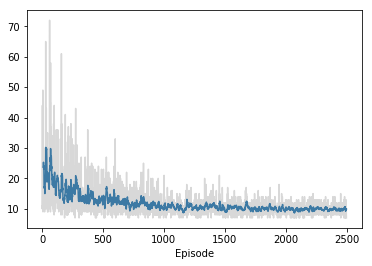

In [26]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0.5,0,'Episode')

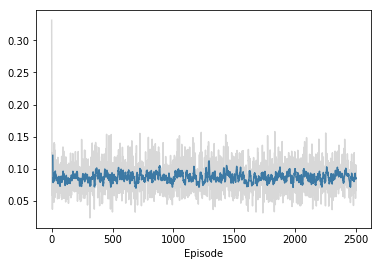

In [27]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

Text(0.5,0,'Episode')

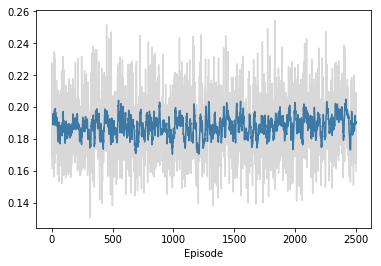

In [28]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [26]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.